# Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `6_svd_steven.ipynb`
### A copy of the notebook Steven created to update the SVD analysis that I am running locally

**Env**: I was using env `rasterio`, and everything was good except the scalebar addition Steven beautifully created.\
So, now I made a copy of `rasterio` called `rasterio_scalebar` which I then pip installed `matplotlib-scalebar`\
That seems to work, so let's proceed...

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
# from matplotlib_scalebar.scalebar import ScaleBar

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# import rioxarray
import rasterio
# import rasterstats
import scipy

# import plotly.express as px

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [3]:
# !pip install matplotlib-scalebar

In [8]:
from matplotlib_scalebar.scalebar import ScaleBar

In [9]:
# ds = xr.open_dataset('~/RAPID/cer_treatment_region_dataset_all_variables/cer_treatment_region_dataset_all_variables.nc') # Steven's path
ds = xr.open_dataset('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_treatment_manuscript\\cer_treatment_region_dataset_all_variables.nc') 


---

In [13]:
ds

<xarray.Dataset>
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 2.111e+05 ... 2.097e+05
  * band                              (band) int32 1
    spatial_ref                       int32 ...
Data variables: (12/337)
    chmws_rapid                       (band, y, x) float32 ...
    dce_rapid                         (band, y, x) float32 ...
    giulia_dce_rapid                  (band, y, x) float32 ...
    giulia_dce_ncalm                  (band, y, x) float32 ...
    slope                             (band, y, x) float32 ...
    aspect                            (band, y, x) float32 ...
    ...                                ...
    hs_rapid_baf_new_100s_n           (band, y, x) float32 ...
    hs_rapid_baf_new_30s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_60s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_80s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_90s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_100s_s           (band, y, x) float32 ...

### Compute Standardized Depth Values (SDV)

We want to compare maps of snow depth on two different years, but rather than compare their depths directly, we will use a standardized depth value (SDV). SDV relates how snow depth in a single pixel or point relates to the mean and standard deviation of snow depths throughout the study area. In this way we can see how a single pixel relates to the snow depths in the study area in year 1, then again in year 2, and see if there was a significant change.

Because we anticipate snow depths changing due to changes in forest structure, we should use the mean and standard deviation of the "control" areas where no human-made forest structure change occurred. Additionally, areas with a snow depth of 0 do not provide us with any information (we don't know how snow in that pixel related to the snow depths across the rest of the study area) and therefore should be removed. Areas with a snow depth of 0 in either year should be removed from *both* years so that we can directly compare changes in pairs of pixels with information in both years.

We can then look at histogram or CDF plots to see how distribution of SDV changed between the two years.

---

In [14]:
from scipy.stats.mstats import mquantiles

def cdf(x):
    x = x[~np.isnan(x)]
    q = np.arange(0,1,0.01)
    y = mquantiles(x, q)
    return (y, q)

Figure showing snow depths from the two years, and difference in snow depths

mean hs_ncalm:  0.21
median hs_ncalm:  0.11
mean hs_rapid:  0.28
median hs_rapid:  0.24
mean hs_diff:  0.07
median hs_diff:  0.06


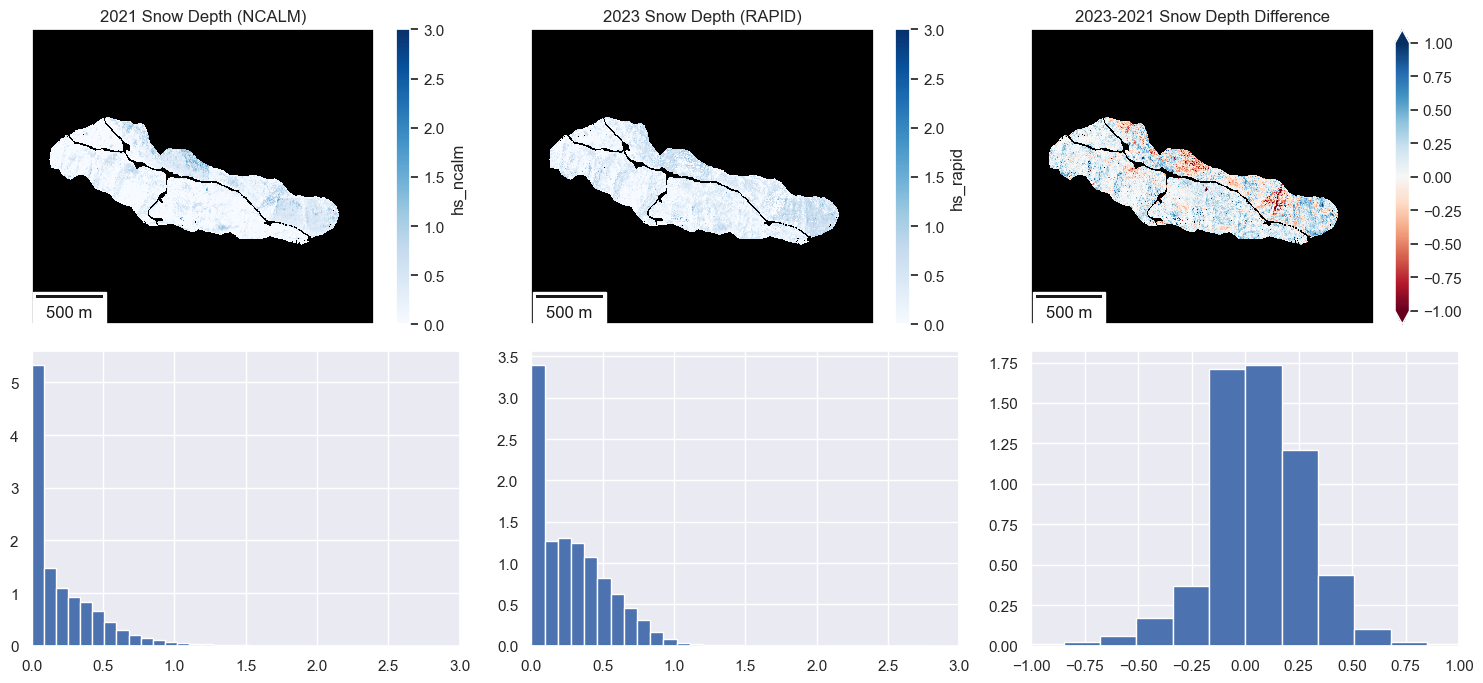

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

ds['hs_ncalm'].plot(ax=ax1, vmin=0, vmax=3, cmap='Blues')
ds['hs_rapid'].plot(ax=ax2, vmin=0, vmax=3, cmap='Blues')
(ds['hs_rapid']-ds['hs_ncalm']).plot(ax=ax3, vmin=-1, vmax=1, cmap='RdBu')

for this_ax in [ax1, ax2, ax3]:
    this_ax.set_facecolor("black")
    scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
    this_ax.add_artist(scalebar)
    this_ax.set_xlabel('')
    this_ax.set_ylabel('') 
    this_ax.set_xticks([])
    this_ax.set_yticks([])

ax1.set_title('2021 Snow Depth (NCALM)')
ax2.set_title('2023 Snow Depth (RAPID)')
ax3.set_title('2023-2021 Snow Depth Difference');

ax4.hist(ds['hs_ncalm'].values.ravel(), density=True, bins=30)
ax5.hist(ds['hs_rapid'].values.ravel(), density=True, bins=30)
ax6.hist((ds['hs_rapid']-ds['hs_ncalm']).values.ravel(), density=True, bins=30)

ax4.set_xlim((0,3))
ax5.set_xlim((0,3))
ax6.set_xlim((-1,1))

print(f'mean hs_ncalm: ', np.round(ds['hs_ncalm'].mean().values,2))
print(f'median hs_ncalm: ', np.round(ds['hs_ncalm'].median().values,2))
print(f'mean hs_rapid: ', np.round(ds['hs_rapid'].mean().values,2))
print(f'median hs_rapid: ', np.round(ds['hs_rapid'].median().values,2))
print(f'mean hs_diff: ', np.round((ds['hs_rapid']-ds['hs_ncalm']).mean().values,2))
print(f'median hs_diff: ', np.round((ds['hs_rapid']-ds['hs_ncalm']).median().values,2))

Before computing SDV, we should remove all locations that had a depth value of 0 in either year 1 or year 2. When we have a depth of 0, we don't actually know how this location compares (in terms of SDV, or number of standard deviations from the mean) with the rest of the study area.

In [16]:
ds['hs_ncalm_zeros_removed'] = ds['hs_ncalm'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))
ds['hs_rapid_zeros_removed'] = ds['hs_rapid'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))

Figure showing snow depths from the two years, and difference in snow depths, now with all areas where snow depth = 0 removed

mean hs_ncalm_zeros_removed:  0.3
median hs_ncalm_zeros_removed:  0.24
mean hs_rapid_zeros_removed:  0.4
median hs_rapid_zeros_removed:  0.38
mean hs_diff_zeros_removed:  0.1
median hs_diff_zeros_removed:  0.11


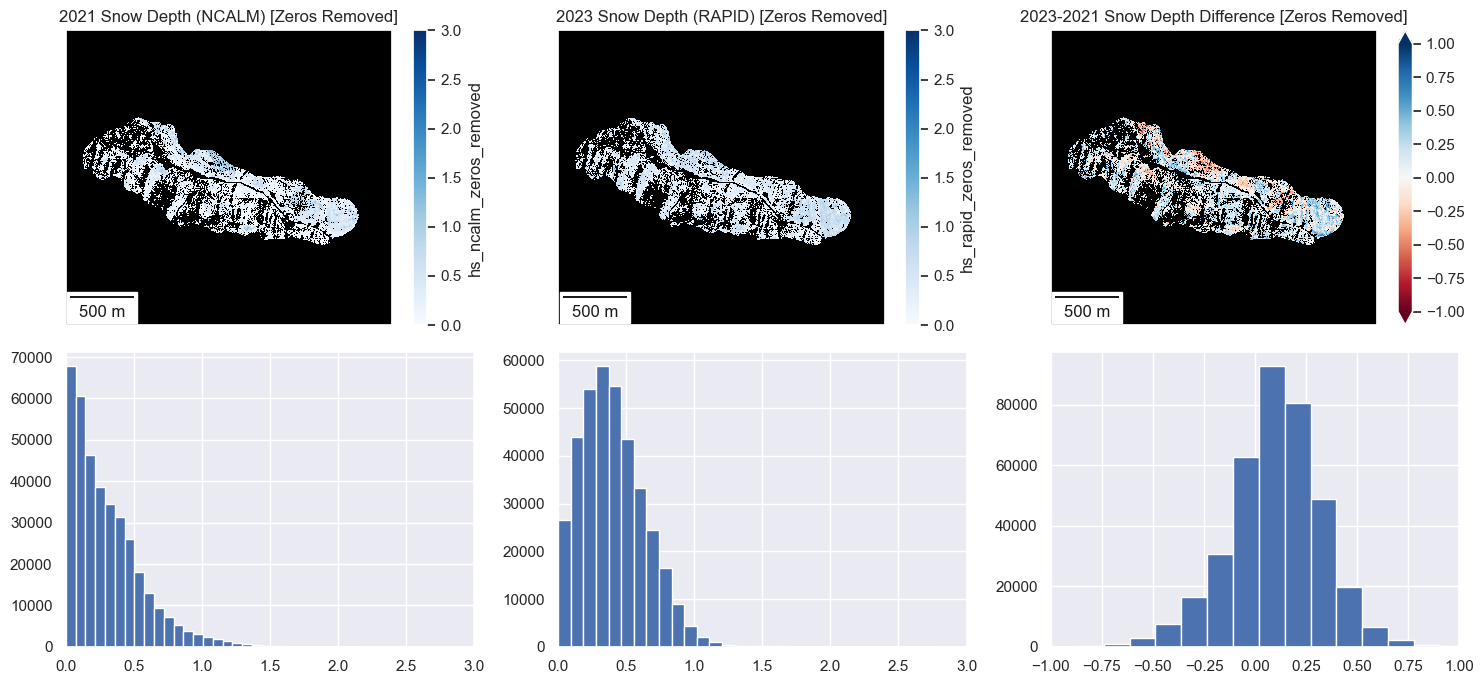

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

ds['hs_ncalm_zeros_removed'].plot(ax=ax1, vmin=0, vmax=3, cmap='Blues')
ds['hs_rapid_zeros_removed'].plot(ax=ax2, vmin=0, vmax=3, cmap='Blues')
(ds['hs_rapid_zeros_removed']-ds['hs_ncalm_zeros_removed']).plot(ax=ax3, vmin=-1, vmax=1, cmap='RdBu')

# create scale bars
for this_ax in [ax1, ax2, ax3]:
    this_ax.set_facecolor("black")
    scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
    this_ax.add_artist(scalebar)
    this_ax.set_xlabel('')
    this_ax.set_ylabel('') 
    this_ax.set_xticks([])
    this_ax.set_yticks([])

ax1.set_title('2021 Snow Depth (NCALM) [Zeros Removed]')
ax2.set_title('2023 Snow Depth (RAPID) [Zeros Removed]')
ax3.set_title('2023-2021 Snow Depth Difference [Zeros Removed]');

ax4.hist(ds['hs_ncalm_zeros_removed'].values.ravel(), bins=30)
ax5.hist(ds['hs_rapid_zeros_removed'].values.ravel(), bins=30)
ax6.hist((ds['hs_rapid_zeros_removed']-ds['hs_ncalm_zeros_removed']).values.ravel(), bins=30)

ax4.set_xlim((0,3))
ax5.set_xlim((0,3))
ax6.set_xlim((-1,1))

print(f'mean hs_ncalm_zeros_removed: ', np.round(ds['hs_ncalm_zeros_removed'].mean().values,2))
print(f'median hs_ncalm_zeros_removed: ', np.round(ds['hs_ncalm_zeros_removed'].median().values,2))
print(f'mean hs_rapid_zeros_removed: ', np.round(ds['hs_rapid_zeros_removed'].mean().values,2))
print(f'median hs_rapid_zeros_removed: ', np.round(ds['hs_rapid_zeros_removed'].median().values,2))
print(f'mean hs_diff_zeros_removed: ', np.round((ds['hs_rapid_zeros_removed']-ds['hs_ncalm_zeros_removed']).mean().values,2))
print(f'median hs_diff_zeros_removed: ', np.round((ds['hs_rapid_zeros_removed']-ds['hs_ncalm_zeros_removed']).median().values,2))

Compute SDV

SDV = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey

We only want to base the SDV mean and standard deviation on the "control areas" where there was no prescribed forest structure change the BAF data variable is NaN for the "control" areas (np.isnan(ds.baf)), and has a value in the "treatment" areas (~np.isnan(ds.baf)).

In [18]:
#.where(np.isnan(ds.baf))
#.where(np.isnan(ds.baf))

ds['sdv_rapid'] = (ds['hs_rapid_zeros_removed'] - ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])
ds['sdv_ncalm'] = (ds['hs_ncalm_zeros_removed'] - ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm'] = (ds['sdv_rapid'] - ds['sdv_ncalm']) # 2023 SDV - 2021 SDV

Plot SDV from both years in the "control" areas only, we hope to see not much of a change in SDV

mean sdv_ncalm_here:  0.0
median sdv_ncalm_here:  -0.25
mean sdv_rapid_here:  0.0
median sdv_rapid_here:  -0.12
mean sdv_diff_here:  0.0
median sdv_diff_here:  -0.01


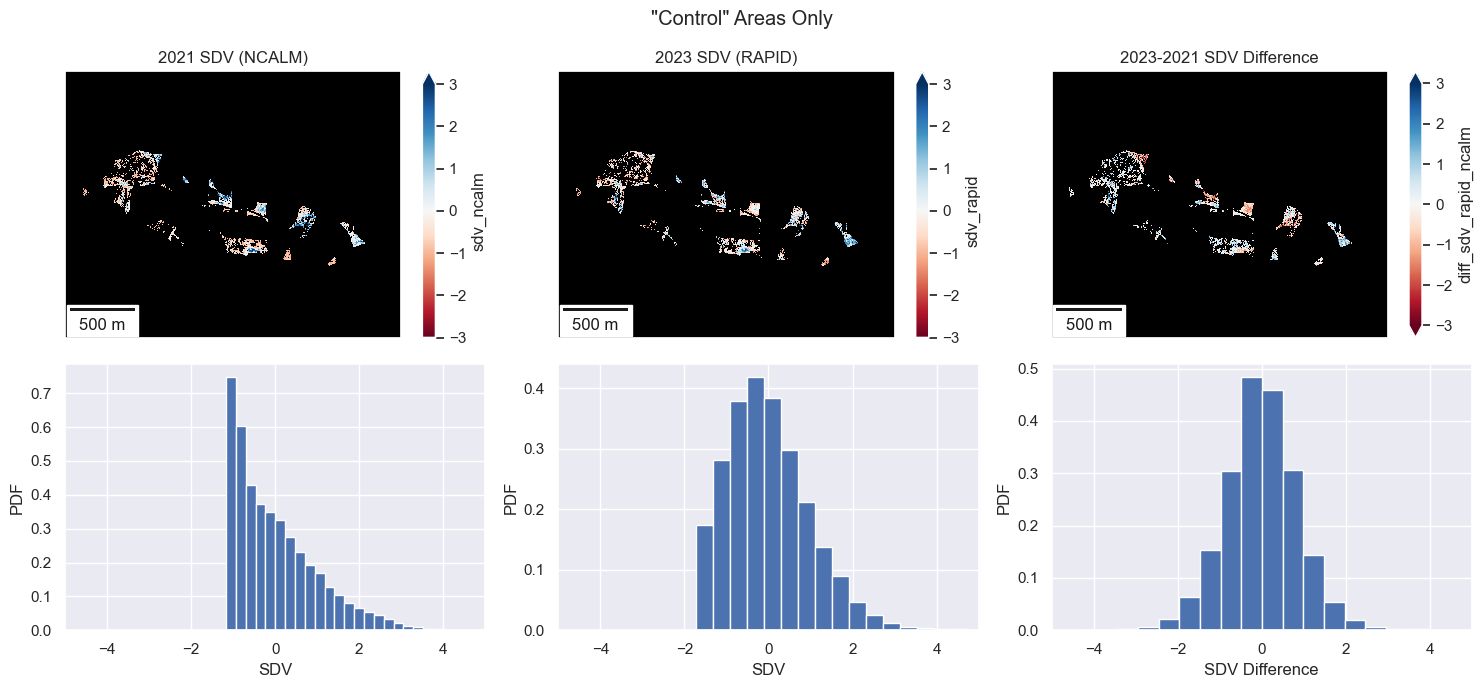

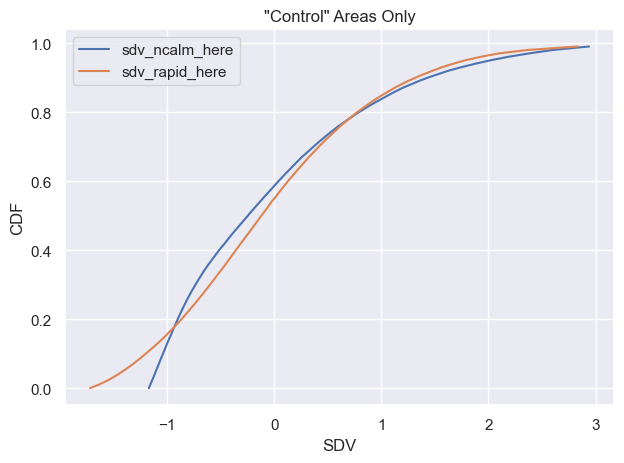

In [19]:
sdv_ncalm_here = ds['sdv_ncalm'].where(np.isnan(ds.baf))
sdv_rapid_here = ds['sdv_rapid'].where(np.isnan(ds.baf))
sdv_diff_here = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf))

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

sdv_ncalm_here.plot(ax=ax1, vmin=-3, vmax=3, cmap='RdBu')
sdv_rapid_here.plot(ax=ax2, vmin=-3, vmax=3, cmap='RdBu')
sdv_diff_here.plot(ax=ax3, vmin=-3, vmax=3, cmap='RdBu')

for this_ax in [ax1, ax2, ax3]:
    this_ax.set_facecolor("black")
    scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
    this_ax.add_artist(scalebar)
    this_ax.set_xlabel('')
    this_ax.set_ylabel('') 
    this_ax.set_xticks([])
    this_ax.set_yticks([])


ax1.set_title('2021 SDV (NCALM)')
ax2.set_title('2023 SDV (RAPID)')
ax3.set_title('2023-2021 SDV Difference');

ax4.hist(sdv_ncalm_here.values.ravel(), density=True, bins=30)
ax5.hist(sdv_rapid_here.values.ravel(), density=True,  bins=30)
ax6.hist(sdv_diff_here.values.ravel(), density=True,  bins=30)

for this_ax in [ax4, ax5, ax6]:
    this_ax.set_xlim((-5,5))
    this_ax.set_ylabel('PDF')
ax4.set_xlabel('SDV')
ax5.set_xlabel('SDV')
ax6.set_xlabel('SDV Difference') 
fig.suptitle('"Control" Areas Only')

print(f'mean sdv_ncalm_here: ', np.round(sdv_ncalm_here.mean().values,2))
print(f'median sdv_ncalm_here: ', np.round(sdv_ncalm_here.median().values,2))
print(f'mean sdv_rapid_here: ', np.round(sdv_rapid_here.mean().values,2))
print(f'median sdv_rapid_here: ', np.round(sdv_rapid_here.median().values,2))
print(f'mean sdv_diff_here: ', np.round(sdv_diff_here.mean().values,2))
print(f'median sdv_diff_here: ', np.round(sdv_diff_here.median().values,2))

fig, ax = plt.subplots(tight_layout=True);
x, y = cdf(sdv_ncalm_here.values.ravel())
ax.plot(x, y, label='sdv_ncalm_here');
x, y = cdf(sdv_rapid_here.values.ravel())
ax.plot(x, y, label='sdv_rapid_here');
#x, y = cdf(sdv_diff_here.values.ravel())
#ax.plot(x, y, label='sdv_diff_here');
ax.set_ylabel('CDF');
ax.set_xlabel('SDV');
ax.set_title('"Control" Areas Only');
plt.legend();

mean sdv_ncalm_here:  -0.38
median sdv_ncalm_here:  -0.63
mean sdv_rapid_here:  -0.17
median sdv_rapid_here:  -0.3
mean sdv_diff_here:  0.2
median sdv_diff_here:  0.15


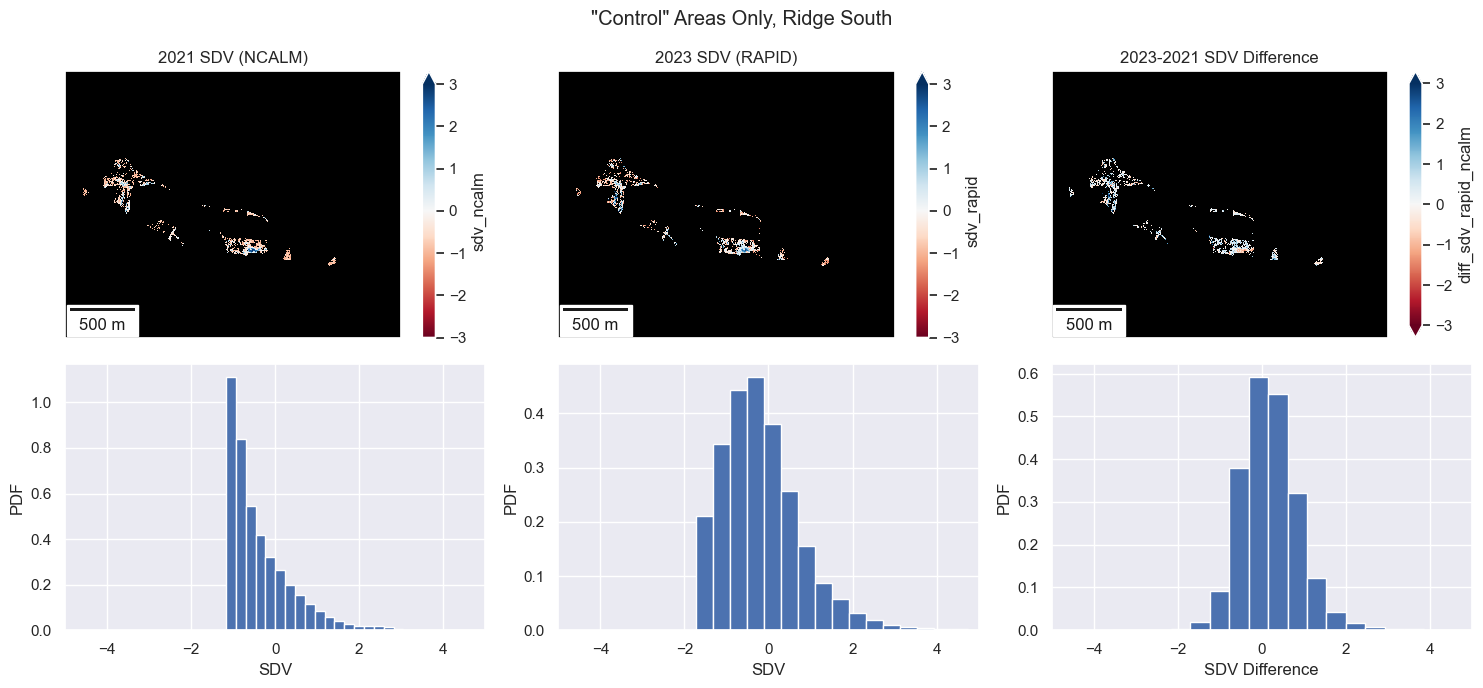

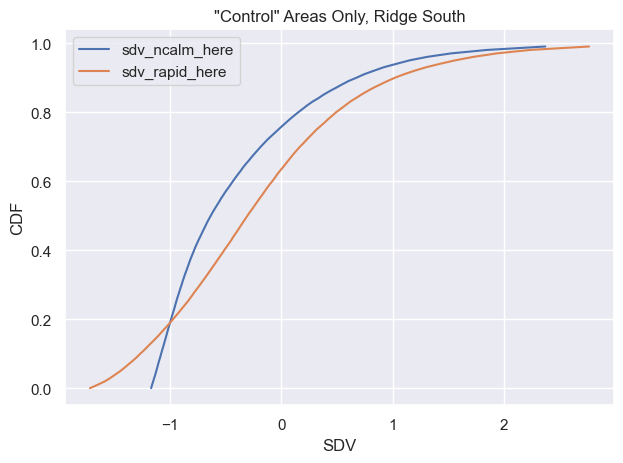

In [20]:
sdv_ncalm_here = ds['sdv_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
sdv_rapid_here = ds['sdv_rapid'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
sdv_diff_here = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

sdv_ncalm_here.plot(ax=ax1, vmin=-3, vmax=3, cmap='RdBu')
sdv_rapid_here.plot(ax=ax2, vmin=-3, vmax=3, cmap='RdBu')
sdv_diff_here.plot(ax=ax3, vmin=-3, vmax=3, cmap='RdBu')

for this_ax in [ax1, ax2, ax3]:
    this_ax.set_facecolor("black")
    scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
    this_ax.add_artist(scalebar)
    this_ax.set_xlabel('')
    this_ax.set_ylabel('') 
    this_ax.set_xticks([])
    this_ax.set_yticks([])


ax1.set_title('2021 SDV (NCALM)')
ax2.set_title('2023 SDV (RAPID)')
ax3.set_title('2023-2021 SDV Difference');

ax4.hist(sdv_ncalm_here.values.ravel(), density=True, bins=30)
ax5.hist(sdv_rapid_here.values.ravel(), density=True,  bins=30)
ax6.hist(sdv_diff_here.values.ravel(), density=True,  bins=30)

for this_ax in [ax4, ax5, ax6]:
    this_ax.set_xlim((-5,5))
    this_ax.set_ylabel('PDF')
ax4.set_xlabel('SDV')
ax5.set_xlabel('SDV')
ax6.set_xlabel('SDV Difference') 

fig.suptitle('"Control" Areas Only, Ridge South')

print(f'mean sdv_ncalm_here: ', np.round(sdv_ncalm_here.mean().values,2))
print(f'median sdv_ncalm_here: ', np.round(sdv_ncalm_here.median().values,2))
print(f'mean sdv_rapid_here: ', np.round(sdv_rapid_here.mean().values,2))
print(f'median sdv_rapid_here: ', np.round(sdv_rapid_here.median().values,2))
print(f'mean sdv_diff_here: ', np.round(sdv_diff_here.mean().values,2))
print(f'median sdv_diff_here: ', np.round(sdv_diff_here.median().values,2))

fig, ax = plt.subplots(tight_layout=True);
x, y = cdf(sdv_ncalm_here.values.ravel())
ax.plot(x, y, label='sdv_ncalm_here');
x, y = cdf(sdv_rapid_here.values.ravel())
ax.plot(x, y, label='sdv_rapid_here');
#x, y = cdf(sdv_diff_here.values.ravel())
#ax.plot(x, y, label='sdv_diff_here');
ax.set_ylabel('CDF');
ax.set_xlabel('SDV');
ax.set_title('"Control" Areas Only, Ridge South');
plt.legend();

mean sdv_ncalm_here:  0.41
median sdv_ncalm_here:  0.25
mean sdv_rapid_here:  0.19
median sdv_rapid_here:  0.11
mean sdv_diff_here:  -0.22
median sdv_diff_here:  -0.28


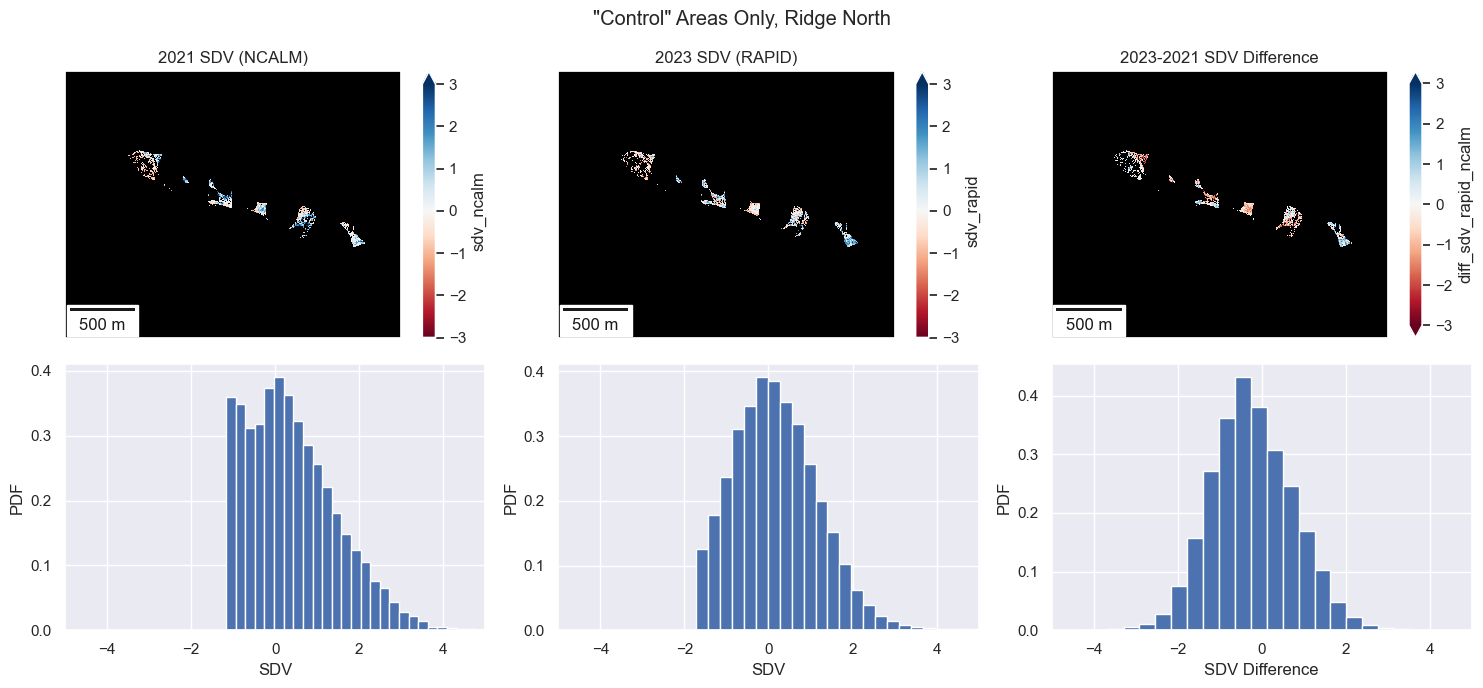

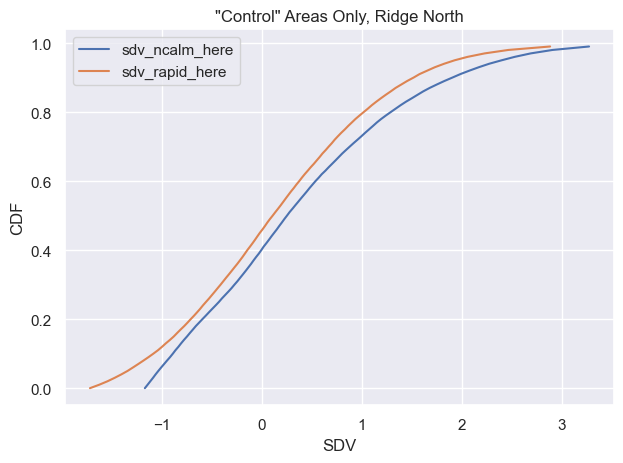

In [21]:
sdv_ncalm_here = ds['sdv_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)
sdv_rapid_here = ds['sdv_rapid'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)
sdv_diff_here = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

sdv_ncalm_here.plot(ax=ax1, vmin=-3, vmax=3, cmap='RdBu')
sdv_rapid_here.plot(ax=ax2, vmin=-3, vmax=3, cmap='RdBu')
sdv_diff_here.plot(ax=ax3, vmin=-3, vmax=3, cmap='RdBu')

for this_ax in [ax1, ax2, ax3]:
    this_ax.set_facecolor("black")
    scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
    this_ax.add_artist(scalebar)
    this_ax.set_xlabel('')
    this_ax.set_ylabel('') 
    this_ax.set_xticks([])
    this_ax.set_yticks([])

ax1.set_title('2021 SDV (NCALM)')
ax2.set_title('2023 SDV (RAPID)')
ax3.set_title('2023-2021 SDV Difference');

ax4.hist(sdv_ncalm_here.values.ravel(), density=True, bins=30)
ax5.hist(sdv_rapid_here.values.ravel(), density=True,  bins=30)
ax6.hist(sdv_diff_here.values.ravel(), density=True,  bins=30)

for this_ax in [ax4, ax5, ax6]:
    this_ax.set_xlim((-5,5))
    this_ax.set_ylabel('PDF')
ax4.set_xlabel('SDV')
ax5.set_xlabel('SDV')
ax6.set_xlabel('SDV Difference') 
fig.suptitle('"Control" Areas Only, Ridge North')

print(f'mean sdv_ncalm_here: ', np.round(sdv_ncalm_here.mean().values,2))
print(f'median sdv_ncalm_here: ', np.round(sdv_ncalm_here.median().values,2))
print(f'mean sdv_rapid_here: ', np.round(sdv_rapid_here.mean().values,2))
print(f'median sdv_rapid_here: ', np.round(sdv_rapid_here.median().values,2))
print(f'mean sdv_diff_here: ', np.round(sdv_diff_here.mean().values,2))
print(f'median sdv_diff_here: ', np.round(sdv_diff_here.median().values,2))

fig, ax = plt.subplots(tight_layout=True);
x, y = cdf(sdv_ncalm_here.values.ravel())
ax.plot(x, y, label='sdv_ncalm_here');
x, y = cdf(sdv_rapid_here.values.ravel())
ax.plot(x, y, label='sdv_rapid_here');
#x, y = cdf(sdv_diff_here.values.ravel())
#ax.plot(x, y, label='sdv_diff_here');
ax.set_ylabel('CDF');
ax.set_xlabel('SDV');
ax.set_title('"Control" Areas Only, Ridge North');
plt.legend();

Now look at SDV in the "treatment" areas only, this is where we expect a change might occur

mean sdv_ncalm_here:  -0.15
median sdv_ncalm_here:  -0.36
mean sdv_rapid_here:  0.05
median sdv_rapid_here:  -0.07
mean sdv_diff_here:  0.2
median sdv_diff_here:  0.16


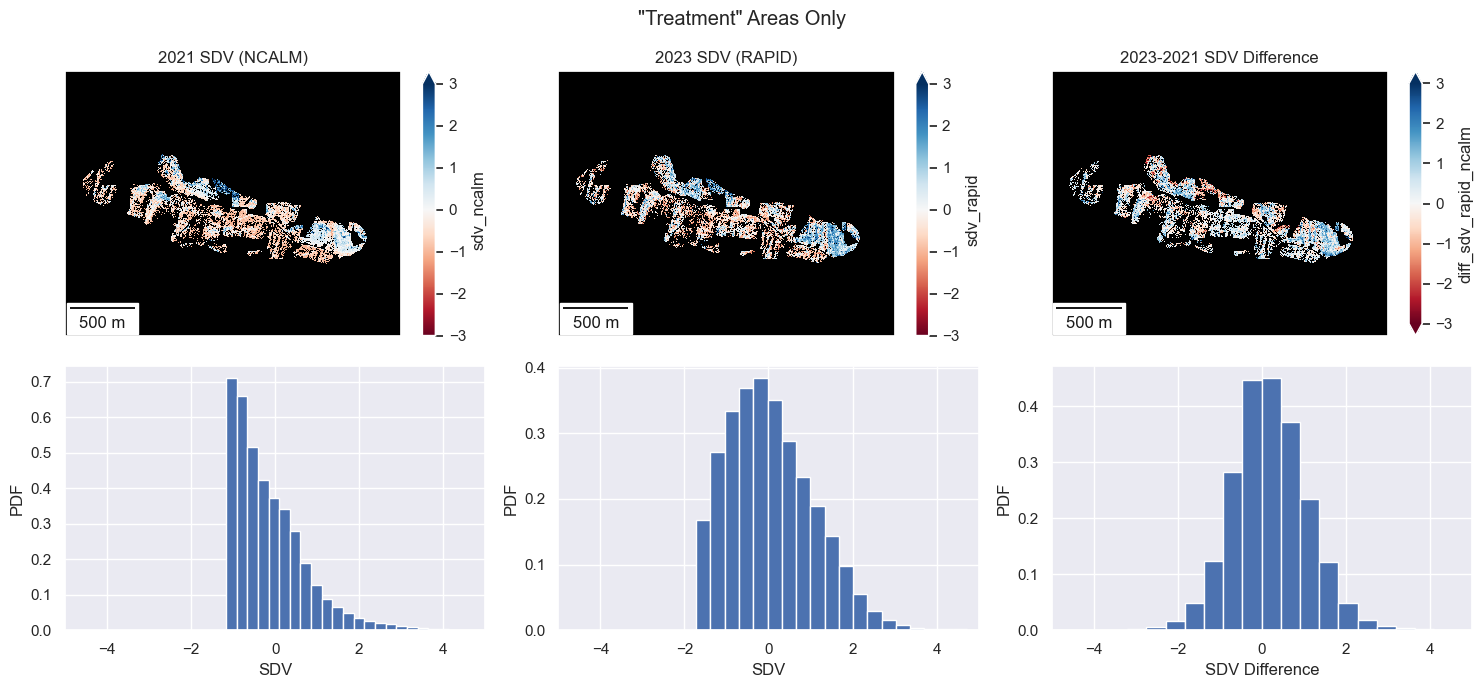

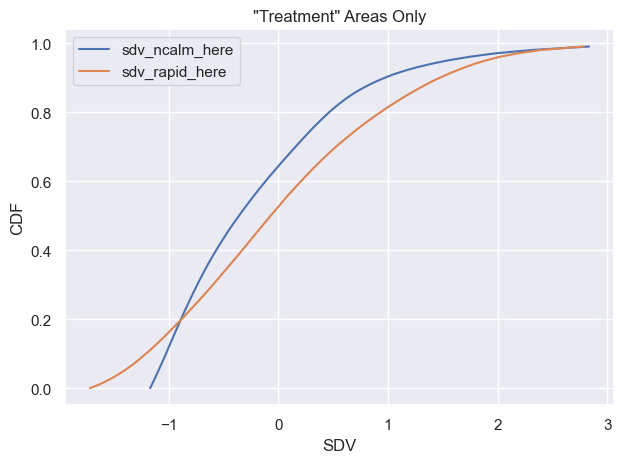

In [22]:
sdv_ncalm_here = ds['sdv_ncalm'].where(~np.isnan(ds.baf))
sdv_rapid_here = ds['sdv_rapid'].where(~np.isnan(ds.baf))
sdv_diff_here = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf))


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

sdv_ncalm_here.plot(ax=ax1, vmin=-3, vmax=3, cmap='RdBu')
sdv_rapid_here.plot(ax=ax2, vmin=-3, vmax=3, cmap='RdBu')
sdv_diff_here.plot(ax=ax3, vmin=-3, vmax=3, cmap='RdBu')

for this_ax in [ax1, ax2, ax3]:
    this_ax.set_facecolor("black")
    scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
    this_ax.add_artist(scalebar)
    this_ax.set_xlabel('')
    this_ax.set_ylabel('') 
    this_ax.set_xticks([])
    this_ax.set_yticks([])

ax1.set_title('2021 SDV (NCALM)')
ax2.set_title('2023 SDV (RAPID)')
ax3.set_title('2023-2021 SDV Difference');

ax4.hist(sdv_ncalm_here.values.ravel(), density=True, bins=30)
ax5.hist(sdv_rapid_here.values.ravel(), density=True,  bins=30)
ax6.hist(sdv_diff_here.values.ravel(), density=True,  bins=30)

for this_ax in [ax4, ax5, ax6]:
    this_ax.set_xlim((-5,5))
    this_ax.set_ylabel('PDF')
ax4.set_xlabel('SDV')
ax5.set_xlabel('SDV')
ax6.set_xlabel('SDV Difference') 
fig.suptitle('"Treatment" Areas Only')

print(f'mean sdv_ncalm_here: ', np.round(sdv_ncalm_here.mean().values,2))
print(f'median sdv_ncalm_here: ', np.round(sdv_ncalm_here.median().values,2))
print(f'mean sdv_rapid_here: ', np.round(sdv_rapid_here.mean().values,2))
print(f'median sdv_rapid_here: ', np.round(sdv_rapid_here.median().values,2))
print(f'mean sdv_diff_here: ', np.round(sdv_diff_here.mean().values,2))
print(f'median sdv_diff_here: ', np.round(sdv_diff_here.median().values,2))

fig, ax = plt.subplots(tight_layout=True);
x, y = cdf(sdv_ncalm_here.values.ravel())
ax.plot(x, y, label='sdv_ncalm_here');
x, y = cdf(sdv_rapid_here.values.ravel())
ax.plot(x, y, label='sdv_rapid_here');
#x, y = cdf(sdv_diff_here.values.ravel())
#ax.plot(x, y, label='sdv_diff_here');
ax.set_ylabel('CDF');
ax.set_xlabel('SDV');
ax.set_title('"Treatment" Areas Only');
plt.legend();

Also, we can look at all areas ("control" and "treatment")

mean sdv_ncalm_here:  -0.11
median sdv_ncalm_here:  -0.34
mean sdv_rapid_here:  0.04
median sdv_rapid_here:  -0.08
mean sdv_diff_here:  0.15
median sdv_diff_here:  0.12


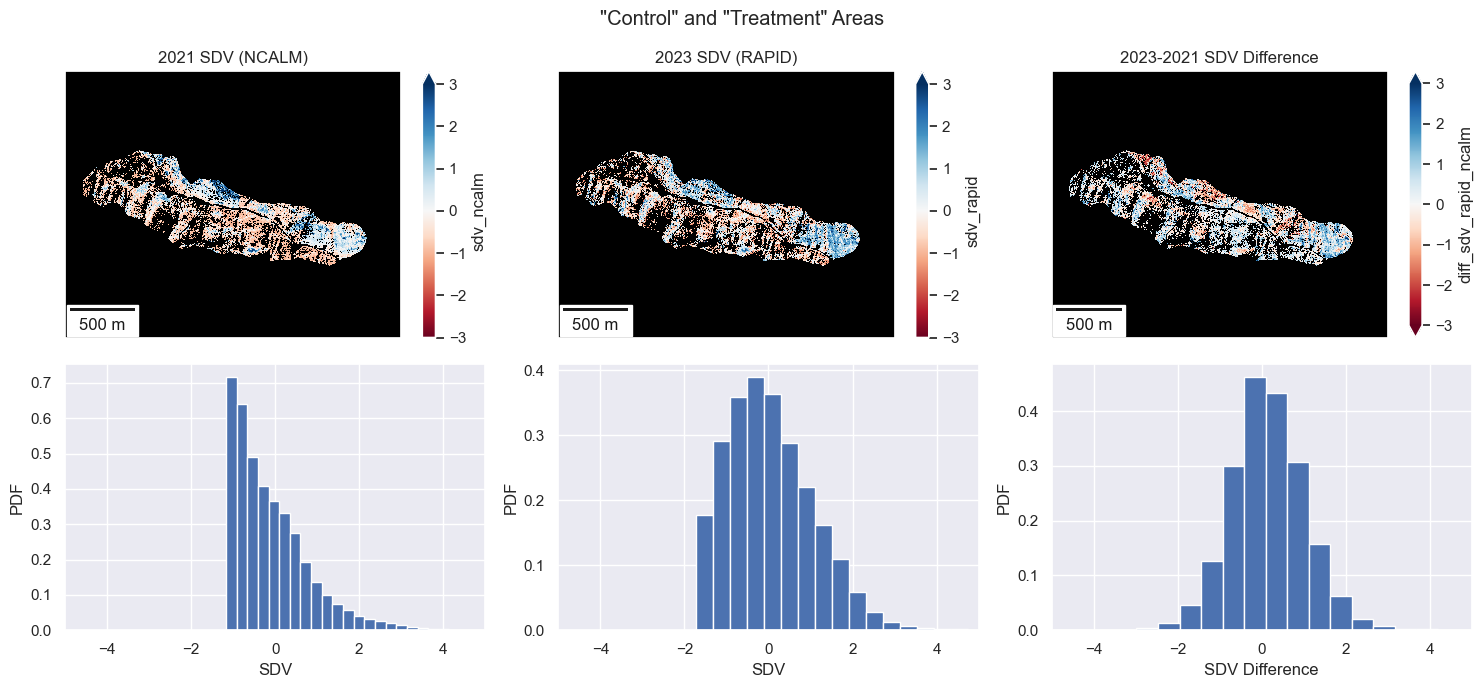

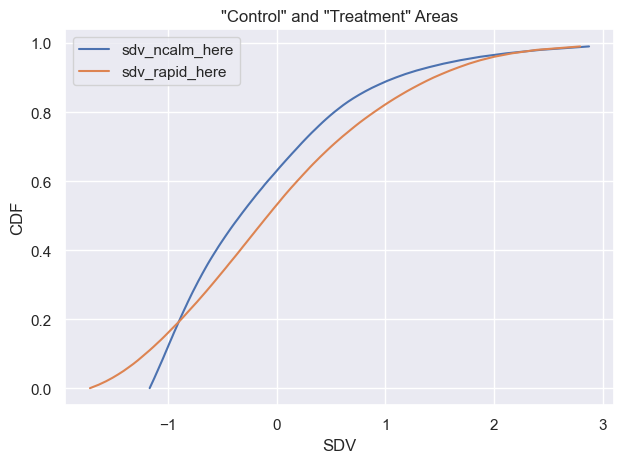

In [23]:
sdv_ncalm_here = ds['sdv_ncalm']
sdv_rapid_here = ds['sdv_rapid']
sdv_diff_here = ds['diff_sdv_rapid_ncalm']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

sdv_ncalm_here.plot(ax=ax1, vmin=-3, vmax=3, cmap='RdBu')
sdv_rapid_here.plot(ax=ax2, vmin=-3, vmax=3, cmap='RdBu')
sdv_diff_here.plot(ax=ax3, vmin=-3, vmax=3, cmap='RdBu')

for this_ax in [ax1, ax2, ax3]:
    this_ax.set_facecolor("black")
    scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
    this_ax.add_artist(scalebar)
    this_ax.set_xlabel('')
    this_ax.set_ylabel('') 
    this_ax.set_xticks([])
    this_ax.set_yticks([])

ax1.set_title('2021 SDV (NCALM)')
ax2.set_title('2023 SDV (RAPID)')
ax3.set_title('2023-2021 SDV Difference');

ax4.hist(sdv_ncalm_here.values.ravel(), density=True, bins=30)
ax5.hist(sdv_rapid_here.values.ravel(), density=True,  bins=30)
ax6.hist(sdv_diff_here.values.ravel(), density=True,  bins=30)

for this_ax in [ax4, ax5, ax6]:
    this_ax.set_xlim((-5,5))
    this_ax.set_ylabel('PDF')
ax4.set_xlabel('SDV')
ax5.set_xlabel('SDV')
ax6.set_xlabel('SDV Difference') 
fig.suptitle('"Control" and "Treatment" Areas')

print(f'mean sdv_ncalm_here: ', np.round(sdv_ncalm_here.mean().values,2))
print(f'median sdv_ncalm_here: ', np.round(sdv_ncalm_here.median().values,2))
print(f'mean sdv_rapid_here: ', np.round(sdv_rapid_here.mean().values,2))
print(f'median sdv_rapid_here: ', np.round(sdv_rapid_here.median().values,2))
print(f'mean sdv_diff_here: ', np.round(sdv_diff_here.mean().values,2))
print(f'median sdv_diff_here: ', np.round(sdv_diff_here.median().values,2))

fig, ax = plt.subplots(tight_layout=True);
x, y = cdf(sdv_ncalm_here.values.ravel())
ax.plot(x, y, label='sdv_ncalm_here');
x, y = cdf(sdv_rapid_here.values.ravel())
ax.plot(x, y, label='sdv_rapid_here');
#x, y = cdf(sdv_diff_here.values.ravel())
#ax.plot(x, y, label='sdv_diff_here');
ax.set_ylabel('CDF');
ax.set_xlabel('SDV');
ax.set_title('"Control" and "Treatment" Areas');
plt.legend();

Treatment areas separated by side of the ridge

mean sdv_ncalm_here:  -0.48
median sdv_ncalm_here:  -0.68
mean sdv_rapid_here:  -0.33
median sdv_rapid_here:  -0.42
mean sdv_diff_here:  0.15
median sdv_diff_here:  0.1


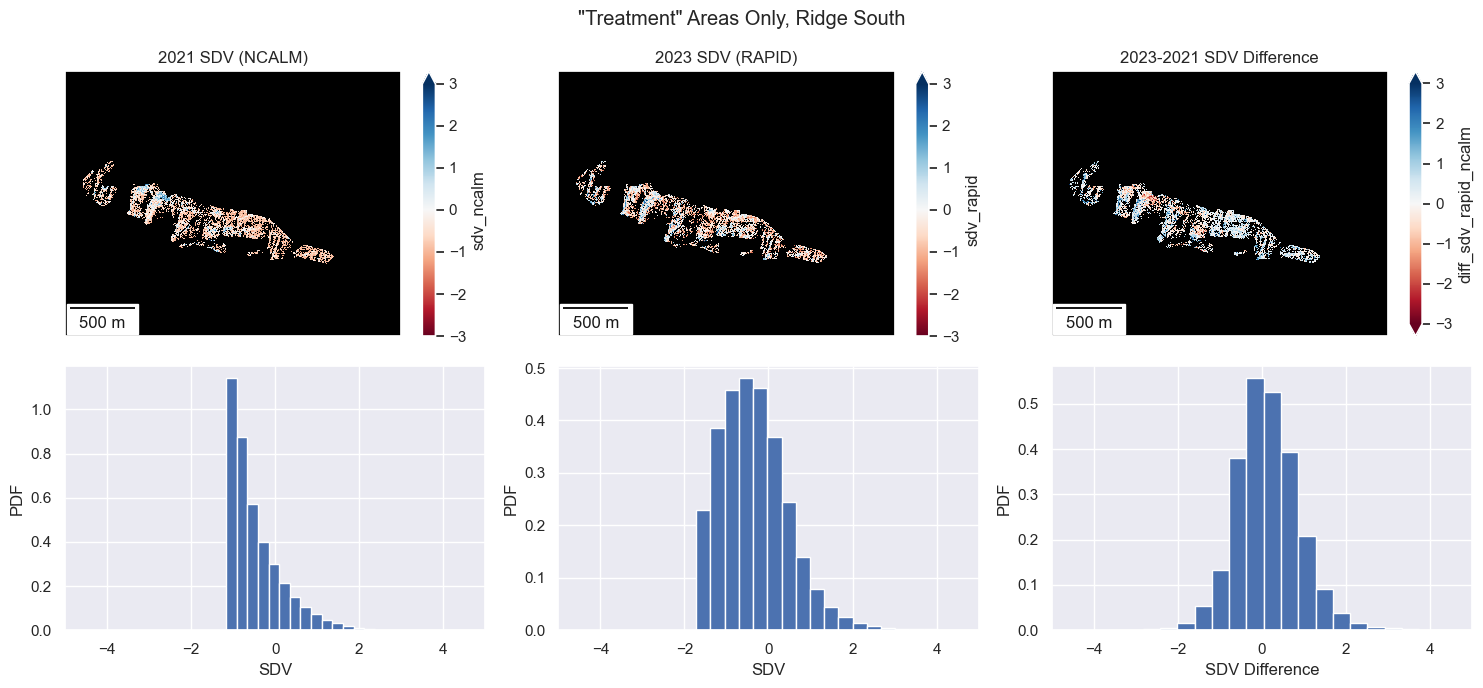

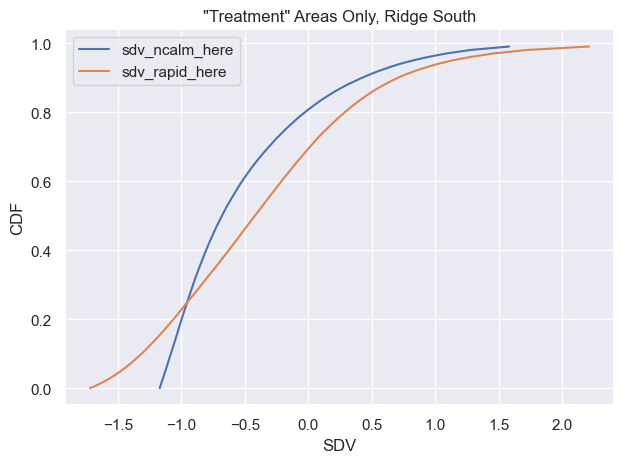

In [24]:
sdv_ncalm_here = ds['sdv_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
sdv_rapid_here = ds['sdv_rapid'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
sdv_diff_here = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

sdv_ncalm_here.plot(ax=ax1, vmin=-3, vmax=3, cmap='RdBu')
sdv_rapid_here.plot(ax=ax2, vmin=-3, vmax=3, cmap='RdBu')
sdv_diff_here.plot(ax=ax3, vmin=-3, vmax=3, cmap='RdBu')

for this_ax in [ax1, ax2, ax3]:
    this_ax.set_facecolor("black")
    scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
    this_ax.add_artist(scalebar)
    this_ax.set_xlabel('')
    this_ax.set_ylabel('') 
    this_ax.set_xticks([])
    this_ax.set_yticks([])

ax1.set_title('2021 SDV (NCALM)')
ax2.set_title('2023 SDV (RAPID)')
ax3.set_title('2023-2021 SDV Difference');

ax4.hist(sdv_ncalm_here.values.ravel(), density=True, bins=30)
ax5.hist(sdv_rapid_here.values.ravel(), density=True,  bins=30)
ax6.hist(sdv_diff_here.values.ravel(), density=True,  bins=30)

for this_ax in [ax4, ax5, ax6]:
    this_ax.set_xlim((-5,5))
    this_ax.set_ylabel('PDF')
ax4.set_xlabel('SDV')
ax5.set_xlabel('SDV')
ax6.set_xlabel('SDV Difference') 
fig.suptitle('"Treatment" Areas Only, Ridge South')

print(f'mean sdv_ncalm_here: ', np.round(sdv_ncalm_here.mean().values,2))
print(f'median sdv_ncalm_here: ', np.round(sdv_ncalm_here.median().values,2))
print(f'mean sdv_rapid_here: ', np.round(sdv_rapid_here.mean().values,2))
print(f'median sdv_rapid_here: ', np.round(sdv_rapid_here.median().values,2))
print(f'mean sdv_diff_here: ', np.round(sdv_diff_here.mean().values,2))
print(f'median sdv_diff_here: ', np.round(sdv_diff_here.median().values,2))

fig, ax = plt.subplots(tight_layout=True);
x, y = cdf(sdv_ncalm_here.values.ravel())
ax.plot(x, y, label='sdv_ncalm_here');
x, y = cdf(sdv_rapid_here.values.ravel())
ax.plot(x, y, label='sdv_rapid_here');
#x, y = cdf(sdv_diff_here.values.ravel())
#ax.plot(x, y, label='sdv_diff_here');
ax.set_ylabel('CDF');
ax.set_xlabel('SDV');
ax.set_title('"Treatment" Areas Only, Ridge South');
plt.legend();

mean sdv_ncalm_here:  0.23
median sdv_ncalm_here:  0.09
mean sdv_rapid_here:  0.48
median sdv_rapid_here:  0.48
mean sdv_diff_here:  0.26
median sdv_diff_here:  0.26


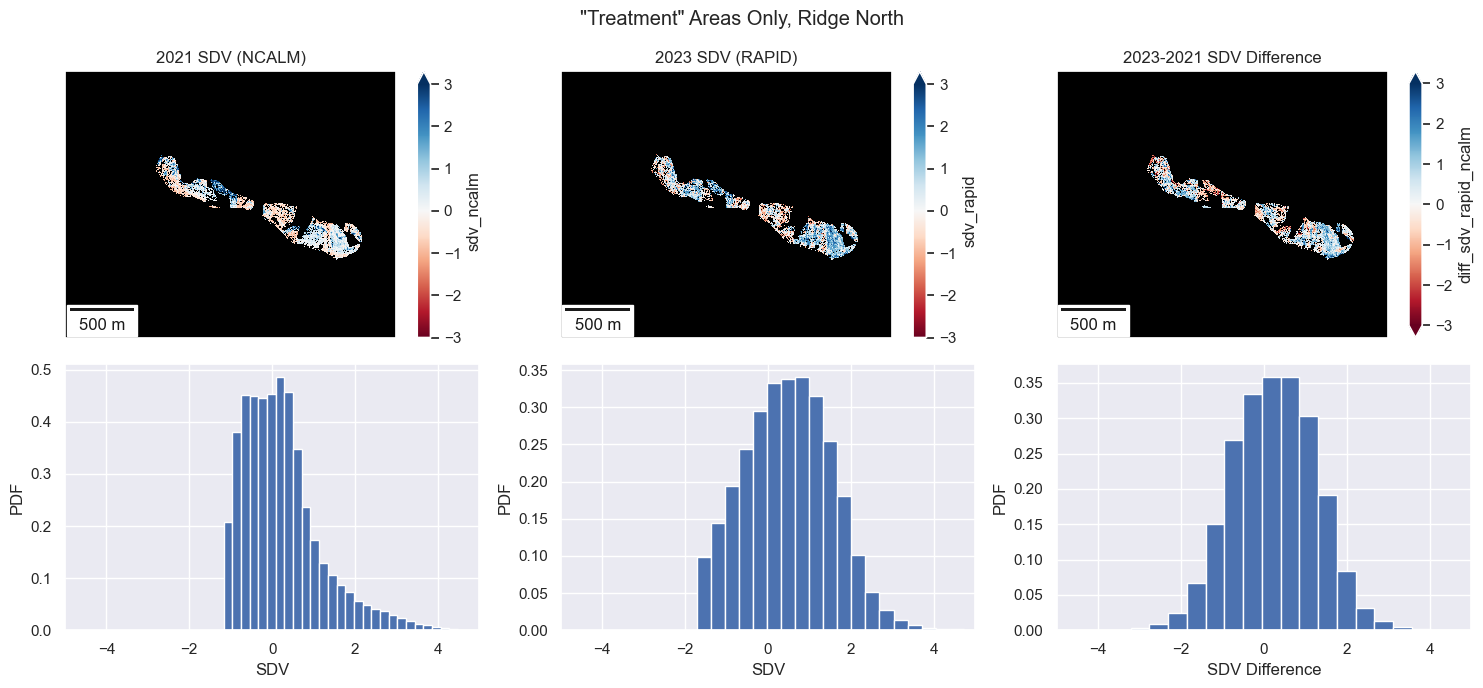

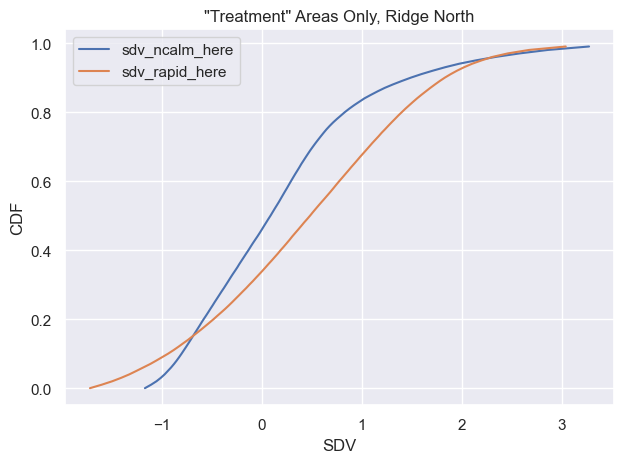

In [25]:

sdv_ncalm_here = ds['sdv_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
sdv_rapid_here = ds['sdv_rapid'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
sdv_diff_here = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

sdv_ncalm_here.plot(ax=ax1, vmin=-3, vmax=3, cmap='RdBu')
sdv_rapid_here.plot(ax=ax2, vmin=-3, vmax=3, cmap='RdBu')
sdv_diff_here.plot(ax=ax3, vmin=-3, vmax=3, cmap='RdBu')

for this_ax in [ax1, ax2, ax3]:
    this_ax.set_facecolor("black")
    scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
    this_ax.add_artist(scalebar)
    this_ax.set_xlabel('')
    this_ax.set_ylabel('') 
    this_ax.set_xticks([])
    this_ax.set_yticks([])

ax1.set_title('2021 SDV (NCALM)')
ax2.set_title('2023 SDV (RAPID)')
ax3.set_title('2023-2021 SDV Difference');

ax4.hist(sdv_ncalm_here.values.ravel(), density=True, bins=30)
ax5.hist(sdv_rapid_here.values.ravel(), density=True,  bins=30)
ax6.hist(sdv_diff_here.values.ravel(), density=True,  bins=30)

for this_ax in [ax4, ax5, ax6]:
    this_ax.set_xlim((-5,5))
    this_ax.set_ylabel('PDF')
ax4.set_xlabel('SDV')
ax5.set_xlabel('SDV')
ax6.set_xlabel('SDV Difference') 
fig.suptitle('"Treatment" Areas Only, Ridge North')

print(f'mean sdv_ncalm_here: ', np.round(sdv_ncalm_here.mean().values,2))
print(f'median sdv_ncalm_here: ', np.round(sdv_ncalm_here.median().values,2))
print(f'mean sdv_rapid_here: ', np.round(sdv_rapid_here.mean().values,2))
print(f'median sdv_rapid_here: ', np.round(sdv_rapid_here.median().values,2))
print(f'mean sdv_diff_here: ', np.round(sdv_diff_here.mean().values,2))
print(f'median sdv_diff_here: ', np.round(sdv_diff_here.median().values,2))

fig, ax = plt.subplots(tight_layout=True);
x, y = cdf(sdv_ncalm_here.values.ravel())
ax.plot(x, y, label='sdv_ncalm_here');
x, y = cdf(sdv_rapid_here.values.ravel())
ax.plot(x, y, label='sdv_rapid_here');
#x, y = cdf(sdv_diff_here.values.ravel())
#ax.plot(x, y, label='sdv_diff_here');
ax.set_ylabel('CDF');
ax.set_xlabel('SDV');
ax.set_title('"Treatment" Areas Only, Ridge North');
plt.legend();

Text(0.5, 1.0, 'Treatment areas only')

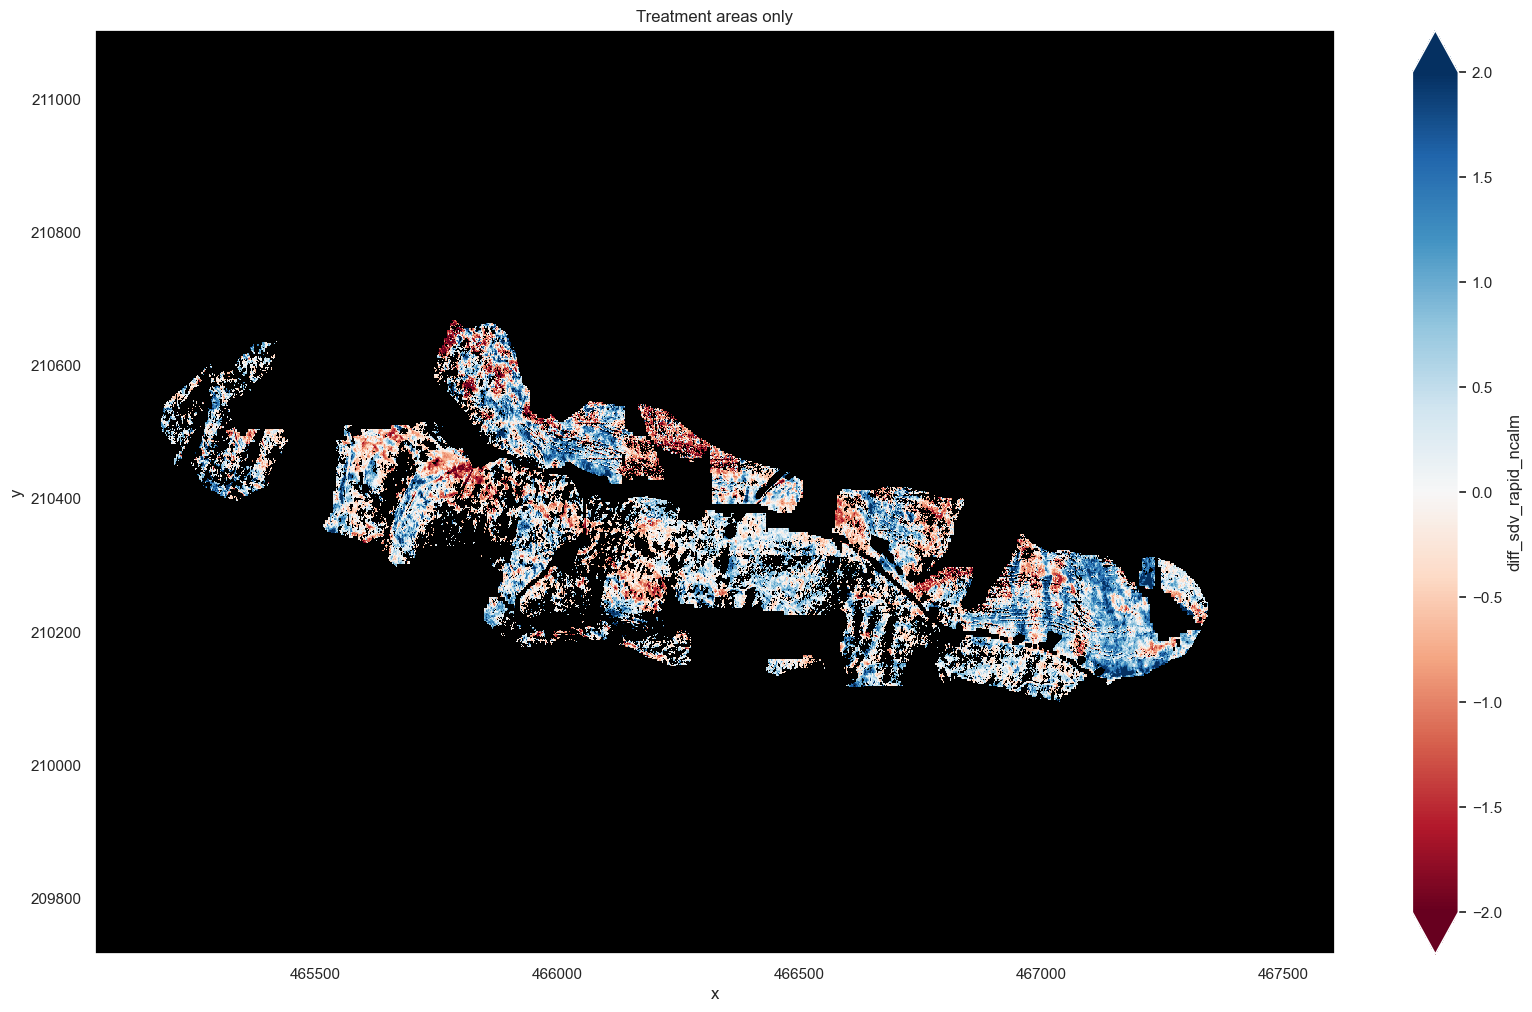

In [26]:
# Treatment areas only
plt.figure(figsize=(20,12))
#ds.baf_ridge.plot( vmin=0, vmax=1000, cmap='Grays', alpha=1, add_colorbar=False)
#ds.baf_ridge.plot( vmin=0, vmax=1, cmap=ListedColormap(['navy','orange']), alpha=0.7, add_colorbar=False)
ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).plot(vmin=-2, vmax=2, cmap='RdBu')
plt.gca().set_facecolor("black")
plt.title('Treatment areas only')

Text(0.5, 1.0, 'Control areas only')

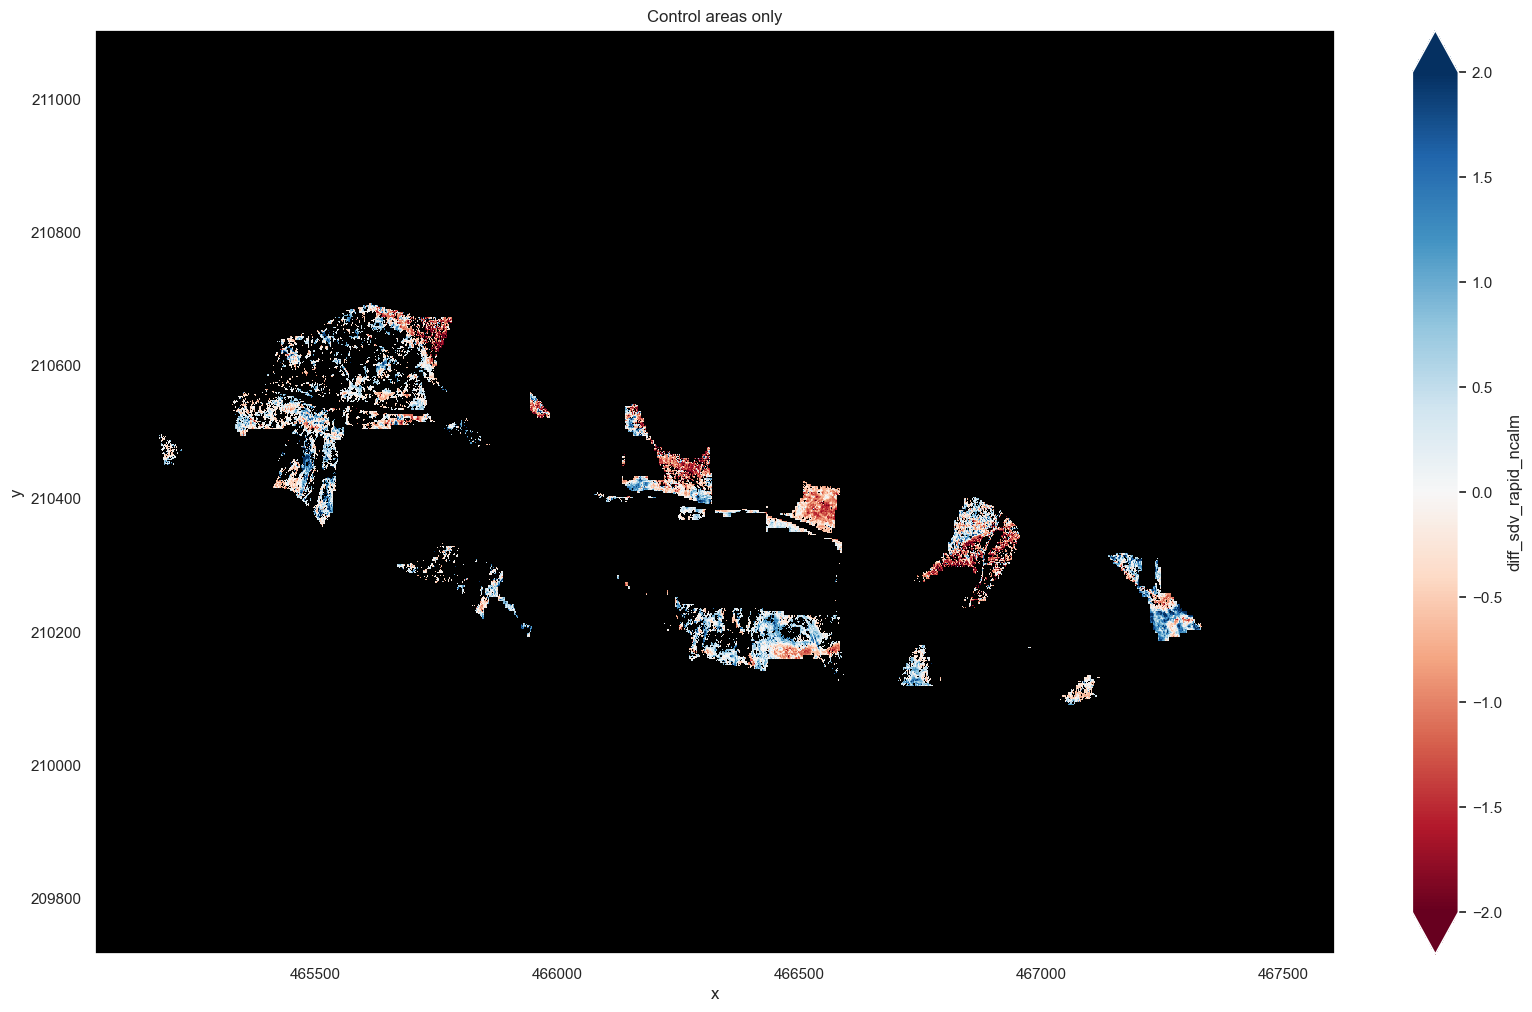

In [27]:
# Control areas only
plt.figure(figsize=(20,12))
ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).plot(vmin=-2, vmax=2, cmap='RdBu')
plt.gca().set_facecolor("black")
plt.title('Control areas only')

Text(0.5, 1.0, 'Entire study area')

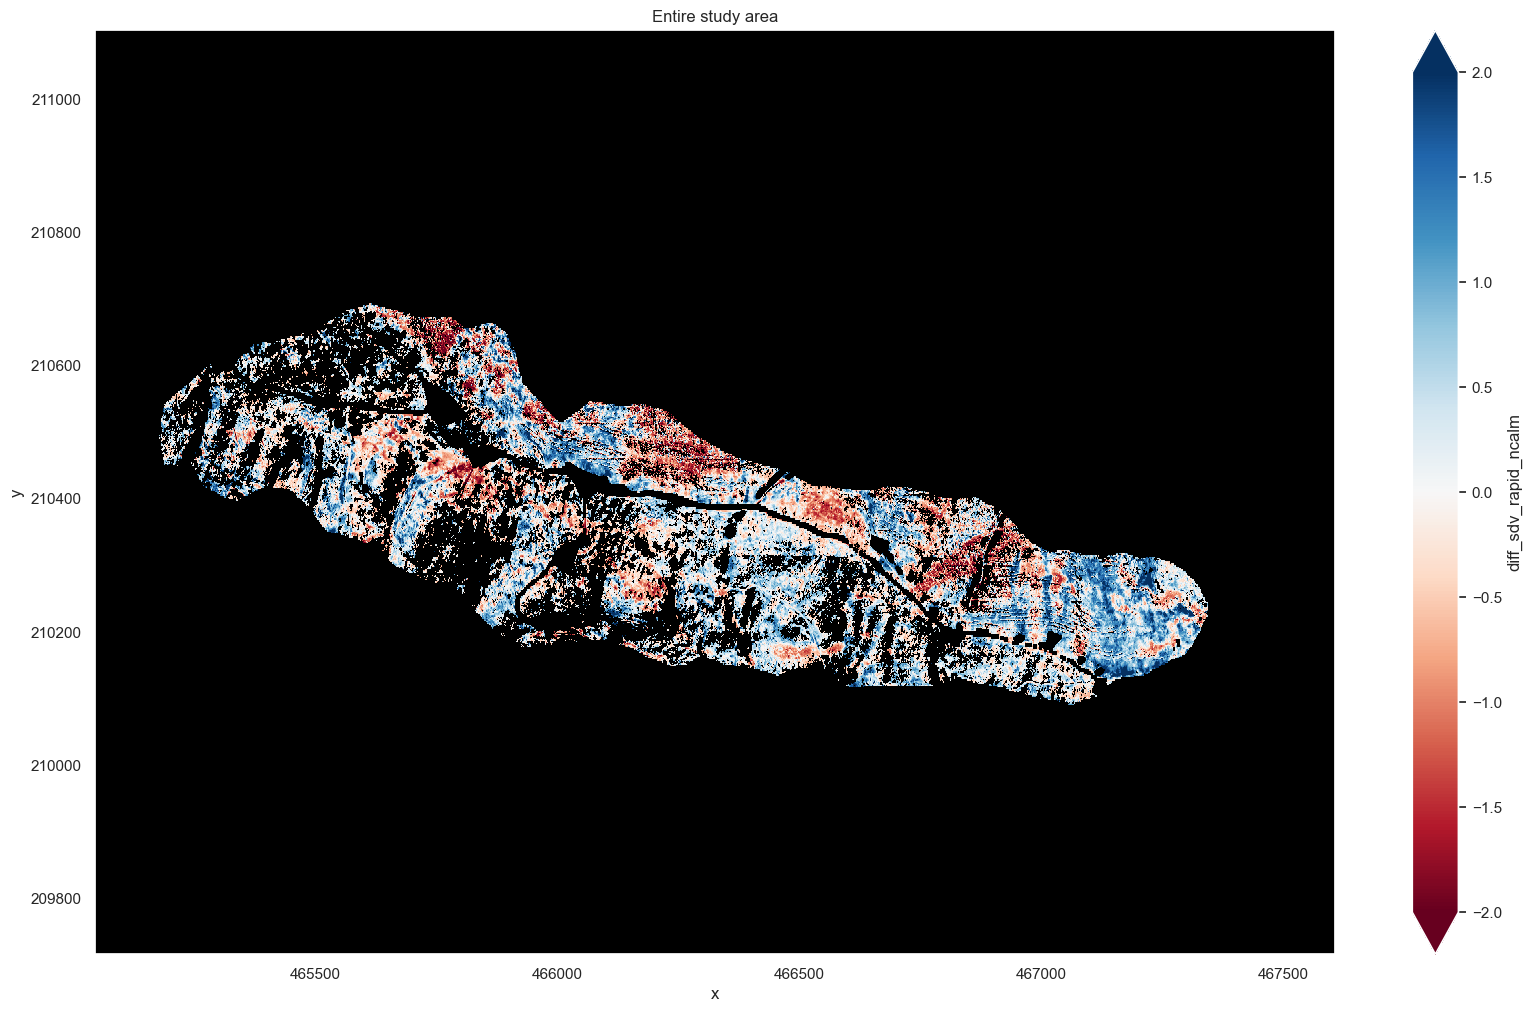

In [28]:
# everywhere
plt.figure(figsize=(20,12))
ds['diff_sdv_rapid_ncalm'].plot(vmin=-2, vmax=2, cmap='RdBu')
plt.gca().set_facecolor("black")
plt.title('Entire study area')

mean sdv_diff_treatments_south:  0.15
median sdv_diff_treatments_south:  0.1
mean sdv_diff_treatments_north:  0.26
median sdv_diff_treatments_north:  0.26
mean sdv_diff_control_south:  0.2
median sdv_diff_control_south:  0.15
mean sdv_diff_control_north:  -0.22
median sdv_diff_control_north:  -0.28


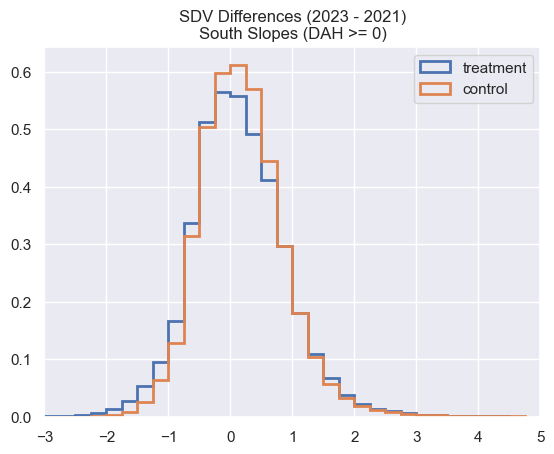

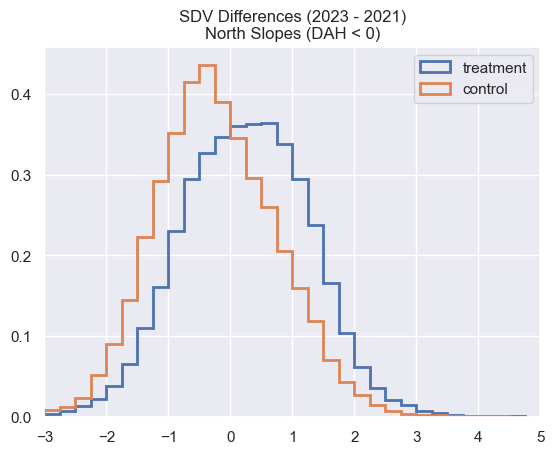

In [29]:
sdv_diff_treatments_south = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
sdv_diff_treatments_north = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
sdv_diff_control_south = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
sdv_diff_control_north = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)


bins = np.arange(-3,5,0.25)

fig, ax = plt.subplots()
ax.hist(sdv_diff_treatments_south.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='treatment') # treatment
ax.hist(sdv_diff_control_south.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='control') # control
ax.set_xlim((-3,5))
plt.legend()
plt.title('SDV Differences (2023 - 2021)\nSouth Slopes (DAH >= 0)')

fig, ax = plt.subplots()
ax.hist(sdv_diff_treatments_north.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='treatment') # treatment
ax.hist(sdv_diff_control_north.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='control') # control 
ax.set_xlim((-3,5))
plt.legend()
plt.title('SDV Differences (2023 - 2021)\nNorth Slopes (DAH < 0)')



print(f'mean sdv_diff_treatments_south: ', np.round(sdv_diff_treatments_south.mean().values,2))
print(f'median sdv_diff_treatments_south: ', np.round(sdv_diff_treatments_south.median().values,2))
print(f'mean sdv_diff_treatments_north: ', np.round(sdv_diff_treatments_north.mean().values,2))
print(f'median sdv_diff_treatments_north: ', np.round(sdv_diff_treatments_north.median().values,2))
print(f'mean sdv_diff_control_south: ', np.round(sdv_diff_control_south.mean().values,2))
print(f'median sdv_diff_control_south: ', np.round(sdv_diff_control_south.median().values,2))
print(f'mean sdv_diff_control_north: ', np.round(sdv_diff_control_north.mean().values,2))
print(f'median sdv_diff_control_north: ', np.round(sdv_diff_control_north.median().values,2))

mean sdv_diff_north:  0.14
median sdv_diff_north:  0.13
mean sdv_diff_south:  0.16
median sdv_diff_south:  0.11


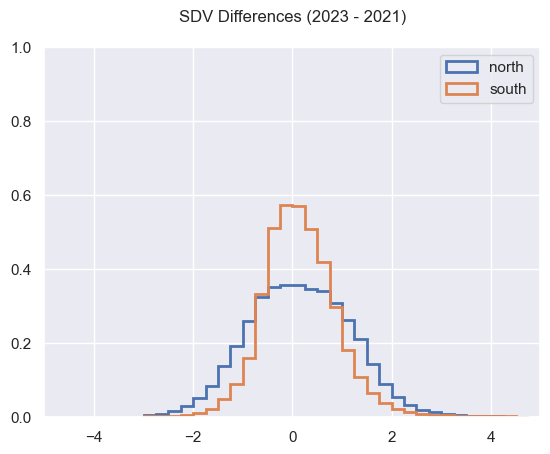

In [30]:
sdv_diff_north = ds['diff_sdv_rapid_ncalm'].where(ds.baf_ridge == -1)
sdv_diff_south = ds['diff_sdv_rapid_ncalm'].where(ds.baf_ridge == 1)


bins = np.arange(-3,5,0.25)

fig, ax = plt.subplots()
ax.hist(sdv_diff_north.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='north') # n
ax.hist(sdv_diff_south.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='south') # s
ax.set_xlim((-3,5))
plt.legend()
plt.title('SDV Differences (2023 - 2021)\n')

ax.set_ylim((0,1))
ax.set_xlim((-5,5))

print(f'mean sdv_diff_north: ', np.round(sdv_diff_north.mean().values,2))
print(f'median sdv_diff_north: ', np.round(sdv_diff_north.median().values,2))
print(f'mean sdv_diff_south: ', np.round(sdv_diff_south.mean().values,2))
print(f'median sdv_diff_south: ', np.round(sdv_diff_south.median().values,2))